<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/Tips_Tricks_56_CPU_vs_GPU_performance_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/d4kj62mH36w

# **A Deep Dive into Why GPUs Outpace CPUs**  A Hands-On Tutorial

FLOPS is commonly used to quantify the computational power of processors and other computing devices. It is an important metric for tasks that involve complex mathematical calculations, such as scientific simulations, artificial intelligence and machine learning algorithms. <p>

FLOPS stands for "Floating Point Operations Per Second" which means the number of floating-point calculations a computer system can perform in one second. The higher the FLOPS value, the faster the computer or processor can perform floating-point calculations, indicating better computational performance.
<p>
In this tutorial, let us use FLOPS as a metric to evaluate the performance of CPU versus GPU. We will begin by employing the DAXPY (Double-precision A*X plus Y) operation, a commonly used operation in numerical computing. This operation involves multiplying a scalar (A) with a vector (X) and adding the result to another vector (Y). We will calculate FLOPS to perform the DAXPY operation using both the CPU and GPU, respectively.
<p>
The DAXPY operation is executed using NumPy operations (A * X + Y). NumPy can leverage optimized implementations, and the actual computation may occur in optimized C or Fortran libraries. Therefore, a more effective way to compare speeds is by conducting matrix multiplications using TensorFlow. The second part of our code is designed to accomplish precisely this task. We will perform matrix multiplications of various-sized matrices and explore how the true advantage of GPUs lies in working with large matrices (datasets in general).



**Let us start by finding out the details of our current hadrware.**

In [1]:
import psutil
import tensorflow as tf

# CPU Information
cpu_info = {
    "Physical Cores": psutil.cpu_count(logical=False),
    "Total Cores": psutil.cpu_count(logical=True),
    "CPU Frequency": psutil.cpu_freq().current,
    "CPU Usage": psutil.cpu_percent(interval=1),
}

print("CPU Information:")
for key, value in cpu_info.items():
    print(f"{key}: {value}")

# GPU Information
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices:
    gpu_info = tf.config.experimental.get_device_details(physical_devices[0])
    print("\nGPU Information:")
    for key, value in gpu_info.items():
        print(f"{key}: {value}")
else:
    print("\nGPU not available on this machine.")


CPU Information:
Physical Cores: 1
Total Cores: 2
CPU Frequency: 2000.202
CPU Usage: 14.4

GPU Information:
compute_capability: (7, 5)
device_name: Tesla T4


At the time of this testing, the GPU offered by Colab is Tesla T4 <br><p>
**Specifications:** <br>
* Turing Tensor Cores. 320. <br>
* **NVIDIA CUDA cores. 2,560.** <br>
* **Single Precision Performance (FP32) 8.1 TFLOPS.**<br>
* Mixed Precision (FP16/FP32) 65 FP16 TFLOPS.<br>
* INT8 Precision. 130 INT8 TOPS.<br>
* INT4 Precision. 260 INT4 TOPS.<br>




**Calculating FLOPS for CPU and GPU using DAXPY**

In [3]:
import numpy as np
import time
import tensorflow as tf

def perform_daxpy(array_size, use_gpu=False):
    if use_gpu:
        device = '/device:GPU:0'
    else:
        device = '/device:CPU:0'

    with tf.device(device):
        # Create NumPy arrays for vectors X, Y, and a scalar A
        A = 2.0  # Scalar
        X = np.random.rand(array_size)
        Y = np.random.rand(array_size)

        # Measure the time taken for the DAXPY operation
        start_time = time.time()
        result = A * X + Y
        end_time = time.time()

        # Calculate FLOPS
        elapsed_time = end_time - start_time
        flops = array_size / elapsed_time

        return flops


# Define the size of the array for the operation
array_size = 10**6  #System crashes for large arrays as they may exceed system memory.

# Perform DAXPY on CPU
cpu_flops = perform_daxpy(array_size, use_gpu=False)
print(f"CPU FLOPS: {cpu_flops:.2e}")

# Perform DAXPY on GPU (if available)
if tf.config.experimental.list_physical_devices('GPU'):
    gpu_flops = perform_daxpy(array_size, use_gpu=True)
    print(f"GPU FLOPS: {gpu_flops:.2e}")
    # Calculate percent difference
    percent_difference = abs((gpu_flops - cpu_flops) / cpu_flops) * 100
    print(f"GPU is {percent_difference:.2f}% faster than CPU.")
else:
    print("GPU not available on this machine.")



CPU FLOPS: 2.56e+08
GPU FLOPS: 3.42e+08
GPU is 33.41% faster than CPU.


We do not see a significant advantage of GPU over CPU. This is because DAXPY is not a suitable operation for this test. Moreover, increasing the array_size for this test beyond 10**6 (at the time of this test) demands additional RAM and crashes the system. Therefore, let us continue our CPU vs GPU speed test using matrix multiplication with the TensorFlow library.

**Testing CPU vs GPU speed using matrix multiplication**

Here, we will verify the GPU speed advantage over CPU for different matrix sizes. The relative efficiency of the GPU compared to the CPU can vary based on the computational demands of the specific task. <p>
In order to make sure we start with a common base line for each matrix multiplication task, we will clear the default graph and release the GPU memory. We will also disable the eager execution in TensorFlow for the matrix multiplication task. Please note that eager execution is a mode that allows operations to be executed immediately as they are called, instead of requiring them to be explicitly executed within a session. Eager execution is enabled by default in TensorFlow 2.x. By disabling eager execution, operations are added to a computation graph, and the graph is executed within a session.

In [4]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

def perform_matmul(matrix_size, use_gpu=False):
    if use_gpu:
        device = '/device:GPU:0'
    else:
        device = '/device:CPU:0'

    with tf.device(device):
        # Reset default graph and clear GPU memory
        tf.compat.v1.reset_default_graph()

        # Create NumPy arrays for matrices A and B
        A = np.random.rand(matrix_size, matrix_size)
        B = np.random.rand(matrix_size, matrix_size)

        # Disable eager execution temporarily
        tf.config.experimental_run_functions_eagerly(False)

        # Measure the time taken for the matrix multiplication
        start_time = time.time()
        result = tf.matmul(A, B)
        end_time = time.time()

        # Enable eager execution again
        tf.config.experimental_run_functions_eagerly(True)

        # Calculate FLOPS
        elapsed_time = end_time - start_time
        flops = 2 * matrix_size**3 / elapsed_time

        # Convert FLOPS to TFLOPS
        tflops = flops / 1e12

        return tflops

# Matrix sizes to test
matrix_sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,
                5000, 7500, 10000]

# Lists to store results
data = {'Matrix Size': [], 'GPU TFLOPS': [], 'CPU TFLOPS': [], 'Percentage Speedup': []}

# Loop through matrix sizes
for matrix_size in matrix_sizes:
    tflops_gpu = perform_matmul(matrix_size, use_gpu=True)
    tflops_cpu = perform_matmul(matrix_size, use_gpu=False)

    # Calculate percentage speedup
    percentage_speedup = ((tflops_gpu - tflops_cpu) / tflops_cpu) * 100

    # Store data in the dictionary
    data['Matrix Size'].append(matrix_size)
    data['GPU TFLOPS'].append(tflops_gpu)
    data['CPU TFLOPS'].append(tflops_cpu)
    data['Percentage Speedup'].append(percentage_speedup)

    # Print results for each matrix size
    print(f"Matrix Size: {matrix_size}, GPU TFLOPS: {tflops_gpu}, CPU TFLOPS: {tflops_cpu}")
    print(f"GPU is {percentage_speedup:.2f}% faster than CPU.\n")

# Create a DataFrame from the collected data
df = pd.DataFrame(data)



Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


Matrix Size: 100, GPU TFLOPS: 1.5799986815463578e-05, CPU TFLOPS: 0.0009599047945989244
GPU is -98.35% faster than CPU.

Matrix Size: 200, GPU TFLOPS: 0.0005992825989891232, CPU TFLOPS: 0.008634696860524961
GPU is -93.06% faster than CPU.

Matrix Size: 300, GPU TFLOPS: 0.022977824490210002, CPU TFLOPS: 0.011799552800208387
GPU is 94.73% faster than CPU.

Matrix Size: 400, GPU TFLOPS: 0.06104274155770324, CPU TFLOPS: 0.016616246115753637
GPU is 267.37% faster than CPU.

Matrix Size: 500, GPU TFLOPS: 0.06747159127469275, CPU TFLOPS: 0.015129875189380276
GPU is 345.95% faster than CPU.

Matrix Size: 600, GPU TFLOPS: 0.14157988185654008, CPU TFLOPS: 0.016796033778585268
GPU is 742.94% faster than CPU.

Matrix Size: 700, GPU TFLOPS: 0.13017656173370132, CPU TFLOPS: 0.012909661942130035
GPU is 908.37% faster than CPU.

Matrix Size: 800, GPU TFLOPS: 0.13311536637222995, CPU TFLOPS: 0.008384759526389255
GPU is 1487.59% faster than CPU.

Matrix Size: 900, GPU TFLOPS: 0.20332807660593163, CPU TF

How come CPU is faster than GPU for small matrix sizes? <br>
For small matrices, the computational advantage of the GPU may not outweigh the associated overhead and warm-up time. As the matrix size increases, the GPU's parallel processing capability becomes more effective

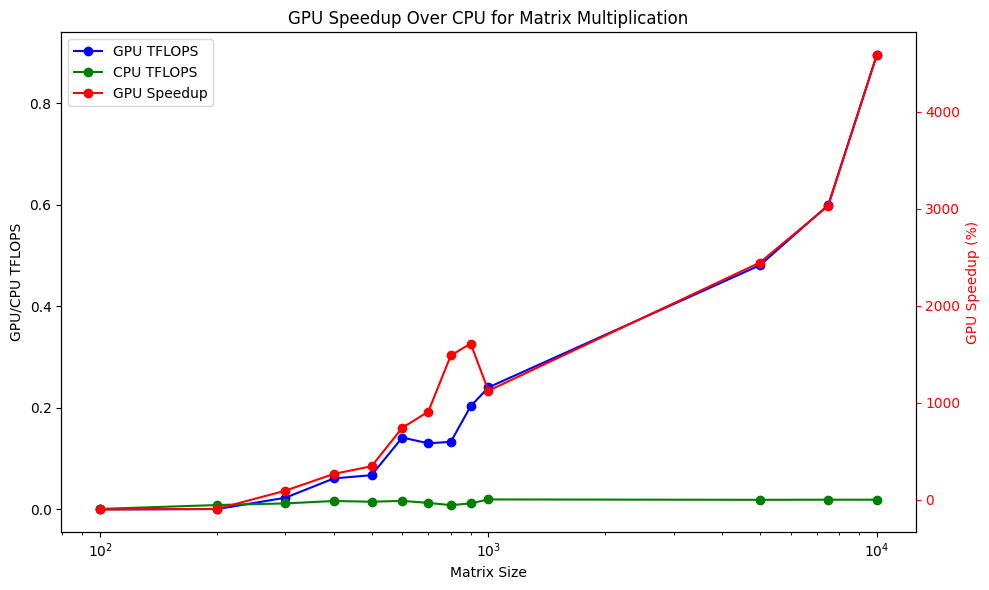

In [5]:
# Plotting the results with CPU and GPU TFLOPS, and Percentage Speedup
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot GPU TFLOPS on the primary y-axis
gpu_tflops_line, = ax1.plot(df['Matrix Size'], df['GPU TFLOPS'], marker='o', linestyle='-', color='blue', label='GPU TFLOPS')
cpu_tflops_line, = ax1.plot(df['Matrix Size'], df['CPU TFLOPS'], marker='o', linestyle='-', color='green', label='CPU TFLOPS')
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('GPU/CPU TFLOPS', color='black')
ax1.tick_params('y', colors='black')

# Create a secondary y-axis for Percentage Speedup
ax2 = ax1.twinx()
speedup_line, = ax2.plot(df['Matrix Size'], df['Percentage Speedup'], marker='o', linestyle='-', color='red', label='GPU Speedup')
ax2.set_ylabel('GPU Speedup (%)', color='red')
ax2.tick_params('y', colors='red')

# Add legend
lines = [gpu_tflops_line, cpu_tflops_line, speedup_line]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.title('GPU Speedup Over CPU for Matrix Multiplication')
fig.tight_layout()
plt.show()


**Summary of our experiment:**
 <p>
 GPU is highly effective in handling larger and more computationally intensive tasks. On the other hand, the CPU's performance appears to plateau with the matrix size.

# Forget FLOPS, it's all about the memory bandwidth!!!


*   Memory bandwidth is a measure of how quickly data can be transferred between the processor (CPU or GPU) and the memory.
*   High memory bandwidth is crucial for tasks that involve frequent access to large datasets (e.g., deep learning training)

* Memory bandwidth becomes particularly important when dealing with large matrices, as transferring data between the processor and memory efficiently can significantly impact overall performance.




